<small><font color=gray>Notebook authors: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, Kiryll Bykov, Alexey Boldyrev ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>🪐Venus vs Mars</font>](https://www.kaggle.com/competitions/19feb24hse-venusmars/rules)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

<small>**CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes.

At first take kaggle.json from https://www.kaggle.com/settings/account "Create New Token"

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Mounted at /content/drive


In [ ]:
%%capture
pip install -U kaggle  # upgrade kaggle package (to avoid a warning)

In [ ]:
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# !cp kaggle.json ~/.kaggle/kaggle.json           # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 19feb24hse-venusmars # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download                     # download competition dataset as a zip file
!unzip -o *.zip                                   # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

Streaming output truncated to the last 5000 lines.
  inflating: train/female/fx104cf.jpg  
  inflating: train/female/fx104d6.jpg  
  inflating: train/female/fx104d7.jpg  
  inflating: train/female/fx104dd.jpg  
  inflating: train/female/fx1051d.jpg  
  inflating: train/female/fx1055d.jpg  
  inflating: train/female/fx105b2.jpg  
  inflating: train/female/fx105b9.jpg  
  inflating: train/female/fx105e7.jpg  
  inflating: train/female/fx105f1.jpg  
  inflating: train/female/fx10637.jpg  
  inflating: train/female/fx10675.jpg  
  inflating: train/female/fx1067f.jpg  
  inflating: train/female/fx10685.jpg  
  inflating: train/female/fx1068f.jpg  
  inflating: train/female/fx106c4.jpg  
  inflating: train/female/fx10742.jpg  
  inflating: train/female/fx10826.jpg  
  inflating: train/female/fx10830.jpg  
  inflating: train/female/fx1087e.jpg  
  inflating: train/female/fx1093e.jpg  
  inflating: train/female/fx109a9.jpg  
  inflating: train/female/fx109b2.jpg  
  inflating: train/female/fx1

See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15360 MiB, 15101 MiB, 0 MiB


In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
from torch.utils.data import random_split
import torch, torchvision
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Sequential, Flatten, Linear, LazyLinear, Dropout, AdaptiveAvgPool2d, MaxPool2d, Conv2d, AvgPool2d
import torchvision
from torchvision.models import resnet50, mobilenet_v2, mobilenet_v3_small
from torchvision.datasets import ImageFolder
import torchvision.transforms as v2
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'train/', 'test/'

CPU times: user 3.56 s, sys: 550 ms, total: 4.11 s
Wall time: 6.48 s


Examples of images from female class

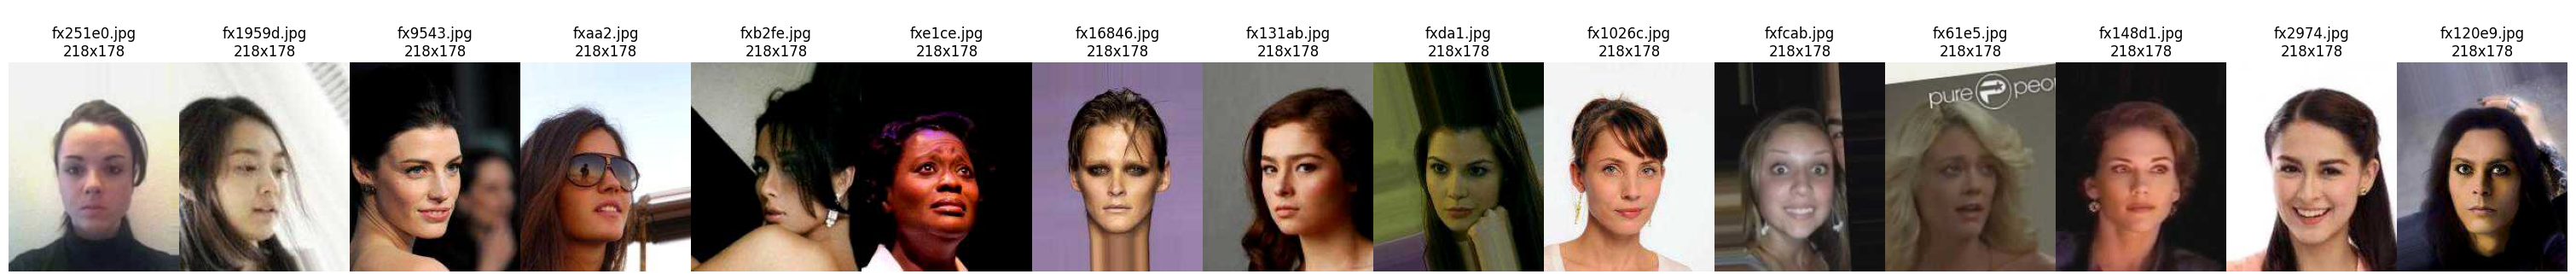

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'female/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'female/'+f);
  _ = ax.set_title(f'\n{f}\n{img.shape[0]}x{img.shape[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

Examples of images from male class

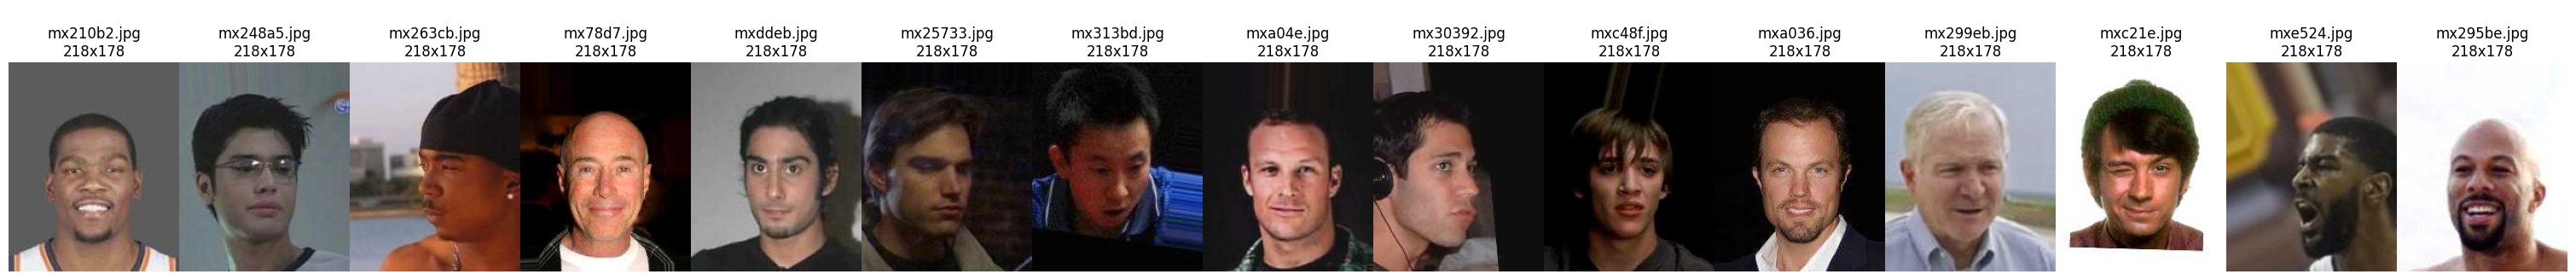

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'male/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'male/'+f);
  _ = ax.set_title(f'\n{f}\n{img.shape[0]}x{img.shape[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>


## **Task 2.1**

**Explain your preprocessing:** we have changed the size of the images to 64x64 in order to take up less memory and improve learning time

## **Task 2.2**

**Explain your modeling approach:**
We implemented a dual-model approach combining a custom-designed Convolutional Neural Network (from paper "Gender classification using custom convolutional neural networks architecture") with a pretrained ResNet18 for a binary classification task. Our CustomCNN, tailored specifically for the data, incorporates convolutional layers, batch normalization, and dropout, culminating in fully connected layers. Concurrently, we adapted the ResNet18, a well-established model, by altering its final layer to suit our classification needs. The training process for both models followed a standard procedure, leveraging the Adam optimizer and a step learning rate scheduler, with cross-entropy as the loss function. To enhance prediction accuracy, we employed an ensemble technique, averaging the output probabilities from both models.


The following cell loads train/validation/test sets as [ImageFolder datasets](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html), `tDS`, `vDS` and `sDS`, respectively.

In [ ]:
BS, image_size = 32, (64, 64)
transform = v2.Compose([v2.ToTensor(), v2.Resize(image_size, antialias=True)])

In [ ]:
!mv test/ labels/ && mkdir test && mv labels/ test/labels/

In [ ]:
im_folder_train = ImageFolder(tDIR, transform=transform)
im_folder_test = ImageFolder(sDIR, transform=transform)

In [ ]:
tDS, vDS = random_split(im_folder_train, lengths=[0.8, 0.2])

In [ ]:
tDL = DataLoader(tDS, batch_size=BS, shuffle=True, pin_memory=True)
vDL = DataLoader(vDS, batch_size=BS, shuffle=False, pin_memory=True)
sDL = DataLoader(im_folder_test, batch_size=BS, shuffle=False, pin_memory=True)

In [ ]:
print(f"Train size: {len(tDS)}")
print(f"Val size: {len(vDS)}")
print(f"Test size: {len(sDL)}")
print(next(iter(tDL))[0][:10].sum())  # to validate seeding of file sampling
print(tDS[0][0].shape)

Train size: 4000
Val size: 1000
Test size: 157
tensor(40514.9141)
torch.Size([3, 64, 64])


This is your baseline DNN model. Remember to [seed all your experiments](https://pytorch.org/docs/stable/notes/randomness.html#reproducibility) for reproducibility.

Below we replace the top layer of the pretrained CNN ([MobileNetV2](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf)) and train the new layer only (all remaining pretrained layers are frozen).

In [ ]:
%%time
torch.manual_seed(0)  # always seed your experiments
torch.cuda.manual_seed_all(0)  # seed all that you can

CPU times: user 1.61 ms, sys: 1.09 ms, total: 2.7 ms
Wall time: 2.39 ms


In [ ]:
# class CustomCNN(nn.Module):
#     def __init__(self):
#         super(CustomCNN, self).__init__()
#         # Define the convolutional layers
#         self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=0)
#         self.bn1 = nn.BatchNorm2d(8)
#         self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0)
#         self.bn2 = nn.BatchNorm2d(16)
#         self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
#         self.bn3 = nn.BatchNorm2d(32)
#         self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(64)
#         # Adjust or add more layers as needed based on your architecture

#         # Define the fully connected layers
#         # Adjust the input size to match the actual size of the flattened feature maps
#         self.fc1 = nn.Linear(1152, 100)  # Adjusted from 2048 to 1152 based on the error message
#         # Define other fully connected layers as per your original design
#         self.fc2 = nn.Linear(100, 50)
#         self.fc3 = nn.Linear(50, 2)

#     def forward(self, x):
#         # Apply convolutional layers and activation functions
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn3(self.conv3(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn4(self.conv4(x)))
#         # Make sure to adjust pooling and convolution operations as needed

#         # Flatten the output for the fully connected layers
#         x = torch.flatten(x, 1)

#         # Apply fully connected layers and activation functions
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)

#         return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# pm1 = Sequential(
#     pm,
#     LazyLinear(1)
# )

In [ ]:
# for l in pm1[0].parameters(): l.requires_grad = False  # freeze layers from training
# sgd = torch.optim.SGD(pm1.parameters(), lr=0.2, momentum=0.9, weight_decay=0.01)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(sgd, gamma=0.01)
# criterion = nn.BCEWithLogitsLoss()
# pm1 = pm1.to(device)

In [ ]:
# model = CustomModel()
# model = model.to(device)


# def trainer(model, epoch=20, validate=True):
#   losses = []
#   acc = []


#   for e in range(epoch):
#     print(f"Epoch: {e}")
#     model.train()
#     for i, (image, label) in enumerate(tDL):


#       image = image.to(device)
#       label = label.to(device).type(torch.float32)
#       sgd.zero_grad()
#       pred = model(image)
#       loss = criterion(pred, label.unsqueeze(1))
#       losses.append(loss)

#       if i % 10 == 0:
#         print(loss)

#       loss.backward()
#       sgd.step()
#       scheduler.step()

#     if validate:
#       model.eval()
#       correct = 0
#       total = 0
#       for i, (image, label) in enumerate(vDL):
#         image = image.to(device)
#         label = label.to(device).type(torch.float32)
#         with torch.no_grad():
#             val_preds = (torch.sigmoid(model(image)) > 0.5).type(torch.int)
#             correct += torch.eq(val_preds, label.unsqueeze(1)).sum().item()
#             total += label.size(0)
#       acc.append(correct / total)
#       print(f"Acc: {correct / total}")
#   plt.plot(acc)
#   return losses

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def trainer(model, tDL, vDL=None, epochs=20, validate=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(tDL):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 0:  # Log every 10 batches
                print(f'Epoch {epoch}, Batch {i}, Loss: {loss.item()}')

        scheduler.step()  # Adjust learning rate
        train_losses.append(running_loss / len(tDL))

        if validate and vDL is not None:
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in vDL:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)
            print(f'Validation Accuracy after Epoch {epoch}: {val_accuracy:.4f}')

    return train_losses, val_accuracies


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Adjusted for 64x64x3 RGB images
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(512)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(512, 100)  # Adjust the size based on the output of the last conv layer
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 2)  # Output layer for 2 classes

    def forward(self, x):
        # Convolutional and pooling layers as before, up to the last conv layer
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), 2)
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), 2)
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))  # Removed the last max pooling layer

        # Dynamically calculate the flattened size
        x = torch.flatten(x, 1)

        # Fully connected layers with ReLU and dropout as before
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        return x

In [ ]:
%%time
model = CustomCNN()
hist = trainer(model, tDL, vDL)

Epoch 0, Batch 0, Loss: 0.7233867049217224
Epoch 0, Batch 10, Loss: 0.6512095928192139
Epoch 0, Batch 20, Loss: 0.6854939460754395
Epoch 0, Batch 30, Loss: 0.6916719675064087
Epoch 0, Batch 40, Loss: 0.6728528141975403
Epoch 0, Batch 50, Loss: 0.6894888281822205
Epoch 0, Batch 60, Loss: 0.7098186016082764
Epoch 0, Batch 70, Loss: 0.6479665040969849
Epoch 0, Batch 80, Loss: 0.7200902104377747
Epoch 0, Batch 90, Loss: 0.6789445281028748
Epoch 0, Batch 100, Loss: 0.6871774196624756
Epoch 0, Batch 110, Loss: 0.73253333568573
Epoch 0, Batch 120, Loss: 0.548385500907898
Epoch 1, Batch 0, Loss: 0.6544736623764038
Epoch 1, Batch 10, Loss: 0.6674363017082214
Epoch 1, Batch 20, Loss: 0.5816819667816162
Epoch 1, Batch 30, Loss: 0.6773324012756348
Epoch 1, Batch 40, Loss: 0.6358507871627808
Epoch 1, Batch 50, Loss: 0.6330190896987915
Epoch 1, Batch 60, Loss: 0.6345381736755371
Epoch 1, Batch 70, Loss: 0.6312721967697144
Epoch 1, Batch 80, Loss: 0.858132004737854
Epoch 1, Batch 90, Loss: 0.58552181

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features

resnet18.fc = nn.Linear(num_ftrs, 2)
resnet18 = resnet18.to(device)

hist_resnet = trainer(resnet18, tDL, vDL)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


Epoch 0, Batch 0, Loss: 0.9129266142845154
Epoch 0, Batch 10, Loss: 1.4412357807159424
Epoch 0, Batch 20, Loss: 0.44471150636672974
Epoch 0, Batch 30, Loss: 0.21432049572467804
Epoch 0, Batch 40, Loss: 0.2568729519844055
Epoch 0, Batch 50, Loss: 0.40357568860054016
Epoch 0, Batch 60, Loss: 0.3476463556289673
Epoch 0, Batch 70, Loss: 0.2837068736553192
Epoch 0, Batch 80, Loss: 0.2326381355524063
Epoch 0, Batch 90, Loss: 0.21418407559394836
Epoch 0, Batch 100, Loss: 0.16419798135757446
Epoch 0, Batch 110, Loss: 0.416277140378952
Epoch 0, Batch 120, Loss: 0.1451198309659958
Epoch 1, Batch 0, Loss: 0.23936380445957184
Epoch 1, Batch 10, Loss: 0.12199442088603973
Epoch 1, Batch 20, Loss: 0.15062294900417328
Epoch 1, Batch 30, Loss: 0.1488327980041504
Epoch 1, Batch 40, Loss: 0.17202891409397125
Epoch 1, Batch 50, Loss: 0.31530052423477173
Epoch 1, Batch 60, Loss: 0.2335384488105774
Epoch 1, Batch 70, Loss: 0.14441393315792084
Epoch 1, Batch 80, Loss: 0.3455030024051666
Epoch 1, Batch 90, Lo

Below we post-train all pre-trained layers after unlocking them.

In [ ]:
# for l in pm1[0].parameters(): l.requires_grad = False  # freeze layers from training
# sgd = torch.optim.SGD(pm1.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(sgd, gamma=0.001)

In [ ]:
# %%time
# hist_trainable = trainer(pm1)

Compile and export predictions:

In [ ]:
vIDs = [f[0].split('/')[-1].split('.')[0] for f in sDL.dataset.imgs] # parse image IDs from file names

In [ ]:
import torch
import pandas as pd
import numpy as np

# Assuming model, sDL, and vIDs are defined as before
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for img, _ in data_loader:
            img = img.to(device)
            output = model(img)
            pred = torch.sigmoid(output)[:, 1]
            predictions.append(pred.cpu().numpy())
    return np.concatenate(predictions, axis=0)

preds_customcnn = get_predictions(model, sDL)
preds_resnet18 = get_predictions(resnet18, sDL)

ensemble_preds = (preds_customcnn + preds_resnet18) / 2

ensemble_binary_preds = (ensemble_preds > 0.5).astype(int)

ensemble_pY = pd.DataFrame(ensemble_binary_preds, index=vIDs, columns=['y'])

if len(ensemble_pY) > 5000:
    ensemble_pY = ensemble_pY.iloc[:-5000]

ensemble_pY.to_csv("🪐-baseline.csv", index_label='id')

CustomCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(256, 512, kernel_size=

CustomCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(256, 512, kernel_size=

# **References:**

1. Gender classification using custom convolutional neural
networks architecture - https://ijece.iaescore.com/index.php/IJECE/article/view/21019
2. MIT DL - https://www.deeplearningbook.org/
3. d2l - https://d2l.ai/

<font size=5>⏳</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 309 sec > 300 sec limit!!!


## 💡**Starter Ideas**

1. Try tuning CNN hyperparameters and architecture
1. Other [pre-trained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) can be faster or more accurate for the given dataset and/or hardware ([benchmarks](https://datascience.stackexchange.com/a/39211/14094))
1. Transforming images via [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)could be faster
1. Identify poorly predicted train images (with near-boundary confidence) and add their augmented versions
1. Identify poorly predicted test images (with near-boundary confidence) and post-train CNN even more on "similar" train images. Similarity can be done in terms of some of the layer(s) of CNN
1. Do you really need all given images? CNN will train faster on a "meaningful" subsample
1. Try ensembling different pretrained CNNs or only their selected layers
1. Try different learning rate for different layers of pretrained models
1. Try cropping instead of resizing images to the fixed $224\times224$ (faces look more naturally if aspect ratio is respected)
1. Try [TPU](https://en.wikipedia.org/wiki/Tensor_Processing_Unit) in Colab. 😮 See [doc example](https://www.tensorflow.org/guide/tpu). Local images should be loaded with [Python I/O](https://stackoverflow.com/a/63147614/3043335), not TF datasets.